# JWST-ERS Clusters
## Spectral Population Synthesis Fitting

The goal of this notebook is to fit some simple JWST prism spectra with [prospector](https://github.com/bd-j/prospector).

In [1]:
import os
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

import fitsio
import nestle
import h5py
from astropy.table import Table, Column

In [2]:
from prospect.utils.smoothing import smoothspec
from prospect.io import write_results
from prospect.sources import CSPSpecBasis

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [4]:
maggies2mJy = 10**(0.4 * 16.4)  # maggies --> mJy
maggies2muJy = 10**(0.4 * 23.9) # maggies --> microJy

### Set the prefix, random seed, and top-level path.

In [5]:
prefix = 'prism'
seed = 123
rand = np.random.RandomState(seed)

jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters')

### Define the key prospector functions.

In [6]:
def load_obs(zred=1.0, wave=None, flux=None, ferr=None, mask=None):
    """Generate the prospector-style "obs" dictionary which contains the input
    photometry, redshift, etc. for a single object.

    Args:
        zred (float): Galaxy redshift.
        wave (np.array, npix): Wavelength array (micron).
        flux (np.array, npix): Galaxy spectrum (units??).
        ferr (np.array, npix): Uncertainty spectrum corresponding to flux (units??).
        mask (np.array, npix): Mask spectrum (1=good, 0=bad).
        
    Returns:
        obs (dict): Dictionary used by prospector.

    """
    obs = {} 

    # Input photometry
    obs['filters'] = None
    obs['maggies'] = None
    obs['maggies_unc'] = None

    # Input spectroscopy
    obs['wavelength'] = wave
    obs['spectrum'] = flux
    obs['unc'] = ferr
    obs['mask'] = mask

    # Store the redshift and any other galaxy properties
    obs['zred'] = zred

    return obs

In [7]:
def logmass2mass(logmass=11.0, **extras):
    return 10**logmass

In [8]:
def logtau2tau(logtau=-1, **extras):
    return 10**logtau

In [9]:
def load_model(zred=1.0, seed=None):
    """Initialize the priors on each free and fixed parameter.

    Args:
      zred (float): input (fixed) galaxy redshift.

    Returns:
      sed (prospect.models.sedmodel.SedModel): SED priors and other stuff.

    Notes:
      FSPS parameters are documented here:
        http://dan.iel.fm/python-fsps/current/stellarpop_api/#api-reference

      Initialization parameters:
        * compute_vega_mags (must be set at initialization)
        * vactoair_flag (must be set at initialization)
        * zcontinuous (must be set at initialization)
    
      Metallicity parameters:
        * zmet (default 1, ignored if zcontinuous>0)
        * logzsol (default 0.0, used if zcontinuous>0)
        * pmetals (default 2.0, only used if zcontinuous=2)

      Dust parameters:
        * add_agb_dust_model (default True)
        * add_dust_emission (default True)
        * cloudy_dust (default False)
        * agb_dust (default 1.0)
        * dust_type (default 0=power law)
        * dust_index, dust1_index
        * dust_tesc
        * dust1 (default 0.0) - extra optical depth towards young stars at 5500A
        * dust2 (default 0.0) - diffuse dust optical depth towards all stars at 5500A
        * dust_clumps, frac_nodust, frac_obrun
        * mwr, uvb, wgp1, wgp2, wgp3, 
        * duste_gamma, duste_umin, duste_qpah

      Star formation history parameters:
        * sfh (default 0=SSP, 1=tau, 4=delayed, 5=truncated delayed tau)
        * tau (default 1)
        * const, sf_start, sf_trunc
        * tage (default 0.0)
        * fburst, tburst, sf_slope
    
      Miscellaneous parameters:
        * add_igm_absorption (default False)
        * igm_factor (default 1.0)
        * smooth_velocity (default True)
        * sigma_smooth, min_wave_smooth, max_wave_smooth
        * redshift_colors (default False, do not use)
        * compute_light_ages (default False, do not use)
       
      Stellar population parameters:
        * add_stellar_remnants (default True)
        * tpagb_norm_type (default 2)
        * dell (default 0.0, do not use)
        * delt (default 0.0, do not use)
        * redgb (default 1.0)
        * fcstar (default 1.0)
        * sbss (default 0.0)
        * fbhb (default 0.0)
        * pagb (default 1.0)
        * imf_type (default 2=Kroupa01)
        * imf1, imf2, imf3, vdmc, mdave, masscut
        * evtype (default 1)
        * tpagb_norm_type

      Emission lines:
        * add_neb_emission (default False)
        * add_neb_continuum (default False)
        * gas_logz (default 0.0)
        * gas_logu (default -2)

      Galaxy properties:
        * zred (default 0.0)

      AGN properties:
        * fagn (default 0.0)
        * agn_tau (default 10)

      Calibration parameters:
        * phot_jitter

    """
    from prospect.models import priors, sedmodel

    model_params = []

    ##################################################
    # Fixed priors

    # Galaxy redshift
    model_params.append({
        'name': 'zred',
        'N': 1,
        'isfree': False,
        'init': zred,
        'units': '',
        'prior': None,       
        })

    model_params.append({ # current mass in stars, not integral of SFH
        'name': 'mass_units',
        'N': 1,
        'isfree': False,
        'init': 'mstar', # 'mformed'
        'prior': None,       
        })

    # IMF (Chabrier)
    model_params.append({
        'name': 'imf_type',
        'N': 1,
        'isfree': False,
        'init':   0, # 0 - Salpeter, 1 - Chabrier
        'units': '',
        'prior': None,       
        })

    # SFH parameterization (delayed-tau)
    model_params.append({
        'name': 'sfh',
        'N': 1,
        'isfree': False,
        'init':   4, # 4 = delayed tau model
        'units': 'type',
        'prior': None,       
        })

    # Do not include dust emission
    model_params.append({
        'name': 'add_dust_emission',
        'N': 1,
        'isfree': False,
        'init':   False, # do not include dust emission
        'units': 'index',
        'prior': None,       
        })

    ##################################################
    # Free priors / parameters

    print('HARD-CODING THE PRIORS!!')
    
    # Priors on stellar mass and stellar metallicity
    logmass_prior = priors.TopHat(mini=9.0, maxi=13.0)#, seed=seed)
    logmass_init = np.diff(logmass_prior.range)/2.0 + logmass_prior.range[0] # logmass_prior.sample()
    model_params.append({
        'name': 'logmass',
        'N': 1,
        'isfree': True,
        'init': 11.0, # logmass_init, # mass, 
        'init_disp': 0.5,     # dex
        'units': r'$M_{\odot}$',
        'prior': logmass_prior,
        })
    
    model_params.append({
        'name': 'mass',
        'N': 1,
        'isfree': False,
        'init': 10**logmass_init,
        'units': '',
        'prior': None,
        'depends_on': logmass2mass,
        })

    logzsol_prior = priors.TopHat(mini=np.log10(0.005/0.019), maxi=np.log10(0.04/0.019))#, seed=seed)
    logzsol_init = np.diff(logzsol_prior.range)/2.0 + logzsol_prior.range[0] # logzsol_prior.sample(), # logzsol,
    model_params.append({
        'name': 'logzsol',
        'N': 1,
        'isfree': True,
        'init': 0.0, # logzsol_init,
        'init_disp': 0.3, # logzsol_prior.range[1] * 0.1,
        'units': r'$\log_{10}\, (Z/Z_\odot)$',
        'prior': logzsol_prior, # roughly (0.2-2)*Z_sun
        })

    # Prior(s) on dust content
    #dust2_prior = priors.TopHat(mini=0.0, maxi=3.0)#, seed=seed)
    #dust2_init = np.diff(dust2_prior.range)/2.0 + dust2_prior.range[0] # dust2_prior.sample(), # dust2,
    #model_params.append({
    #    'name': 'dust2',
    #    'N': 1,
    #    'isfree': True,
    #    'init': dust2_init,
    #    'init_disp': 0.5, # dust2_prior.range[1] * 0.1,
    #    'units': '', # optical depth
    #    'prior': dust2_prior,
    #    })
    
    # Prior on (log)tau
    logtau_prior = priors.TopHat(mini=-3.0, maxi=1.0)#, seed=seed)
    logtau_init = np.diff(logtau_prior.range)/2.0 + logtau_prior.range[0] # logtau_prior.sample()
    model_params.append({
        'name': 'logtau',
        'N': 1,
        'isfree': True,
        'init': -1, # logtau_init, # tau, 
        'init_disp': 0.3, # dex
        'units': 'Gyr',
        'prior': logtau_prior,
        })
    
    model_params.append({
        'name': 'tau',
        'N': 1,
        'isfree': False,
        'init': 10**logtau_init,
        'units': '',
        'prior': None,
        'depends_on': logtau2tau,
        })
    
    # Prior on age
    tage_prior = priors.TopHat(mini=1.0, maxi=5.0)#, seed=seed)
    tage_init = np.diff(tage_prior.range) / 2.0 + tage_prior.range[0] # tage_prior.sample(), # tage,
    model_params.append( {
        'name': 'tage',
        'N': 1,
        'isfree': True,
        'init': 3.0, # tage_init,
        'init_disp': 2.0, # tage_prior.range[1] * 0.1,
        'units': 'Gyr',
        'prior': tage_prior,
        })

    model = sedmodel.SedModel(model_params)
    
    return model

In [10]:
def lnprobfn(theta, spec_noise=None, phot_noise=None, verbose=False):
    """Define the likelihood function.

    Given a parameter vector and a dictionary of observational data and a model
    object, return the ln of the posterior. This requires that an sps object
    (and if using spectra and gaussian processes, a GP object) be instantiated.

    """
    from prospect.likelihood import lnlike_spec, lnlike_phot, chi_spec, chi_phot
    
    lnp_prior = model.prior_product(theta, nested=True)
    if np.isfinite(lnp_prior):
        # Generate the mean model--
        t1 = time.time()
        try:
            model_spec, model_phot, model_extras = model.mean_model(
                theta, obs, sps=sps)#, resolution=run_params['resolution'],
                #smoothtype=run_params['smoothtype'])
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling--
        if spec_noise:
            spec_noise.update(**model.params)
        if phot_noise:
            phot_noise.update(**model.params)

        vectors = {
            'spec': model_spec,    # model spectrum
            'phot': model_phot,    # model photometry
            'sed': model._spec,    # object spectrum
            'cal': model._speccal, # object calibration spectrum
        }

        # Calculate likelihoods--
        t2 = time.time()
        lnp_spec = lnlike_spec(model_spec, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(model_phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if True:
            from prospect.likelihood import write_log
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    else:
        return -np.infty

In [11]:
def load_run_params(prefix, seed=None, resolution=None):
    """Populate the run_params dictionary."""
    run_params = {
        'prefix':  prefix,
        'verbose': True,
        'seed':    seed,
        # Nestle fitting parameters
        'nestle_method': 'single',
        'nestle_npoints': 100,
        'nestle_maxcall': 100, #int(1e6),
        # Smoothing model
        'smoothtype': 'lsf',
        'resolution': resolution,
        # SPS initialization parameters
        'compute_vega_mags': False,
        'vactoair_flag': False, # use wavelengths in air
        'zcontinuous': 1,      # interpolate in metallicity
    }
    return run_params

### Read the instrumental resolution curve and initialize the SSPs.

In [12]:
def read_resolution():
    """Read the JWST/prism instrumental resolution function.
    
    """
    pandeia_dir = os.path.join( os.getenv('IM_DATA_DIR'), 'pandeia_data-1.0' )
    
    dispfile = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'dispersion', 
                            'jwst_nirspec_prism_disp.fits')
    print('Reading {}'.format(dispfile))
    disp = Table(fitsio.read(dispfile, ext=1, upper=True))
    
    return disp

In [13]:
disp = read_resolution()

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/dispersion/jwst_nirspec_prism_disp.fits


### Construct the smoothed, noisy input spectra.

In [14]:
cat = Table.read(os.path.join(jwstdir, 'etc', 'input', 'modelspec.fits'))
nspec = len(cat)

In [15]:
npix = 403 # hard-coded!
cat.add_column(Column(name='SUFFIX', dtype='S2', length=nspec))
cat.add_column(Column(name='JWST_WAVELENGTH', shape=(npix, ), dtype='f4', length=nspec))
cat.add_column(Column(name='JWST_FLUX', shape=(npix, ), dtype='f4', length=nspec))
cat.add_column(Column(name='JWST_FERR', shape=(npix, ), dtype='f4', length=nspec))
cat.add_column(Column(name='RESOLUTION', shape=(npix, ), dtype='f4', length=nspec))

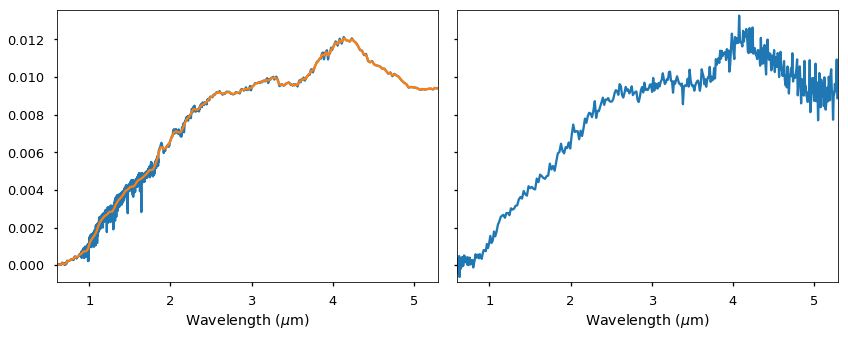

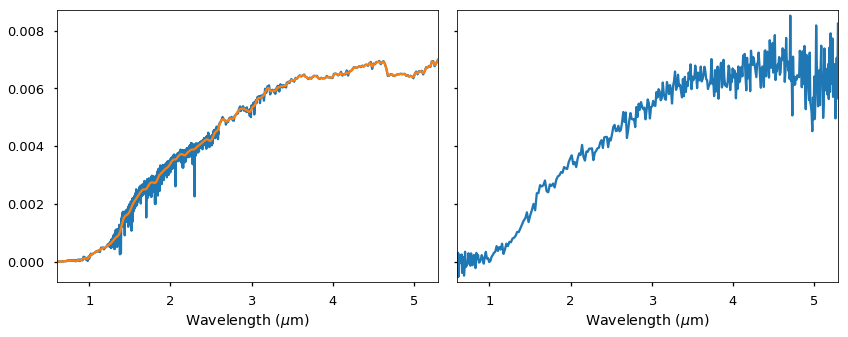

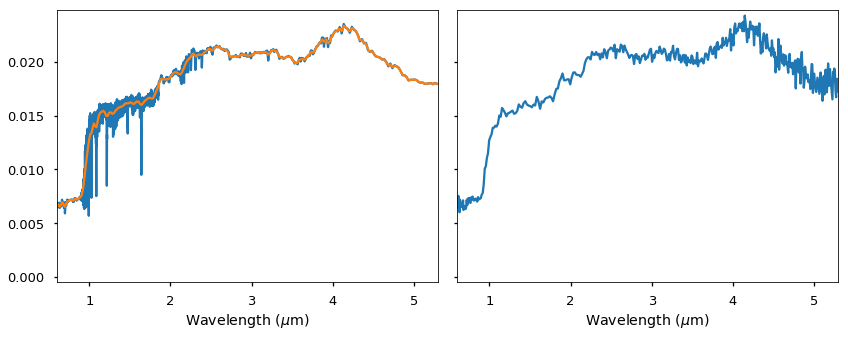

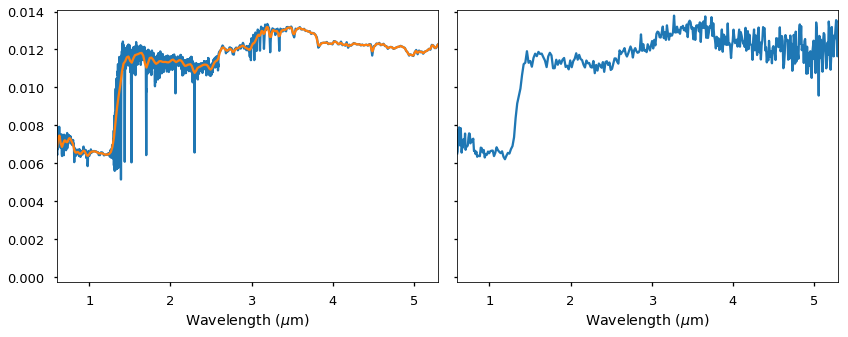

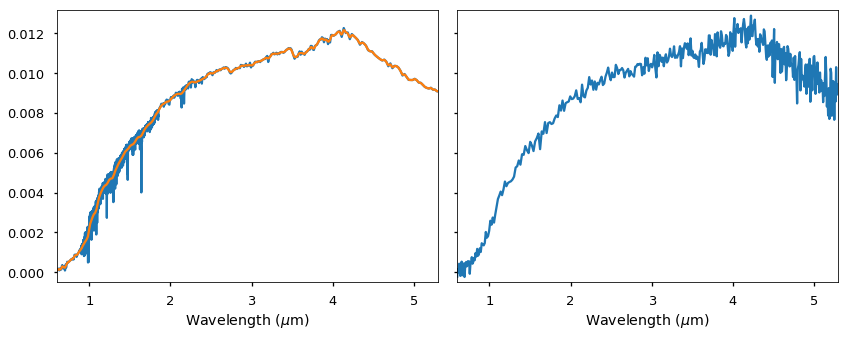

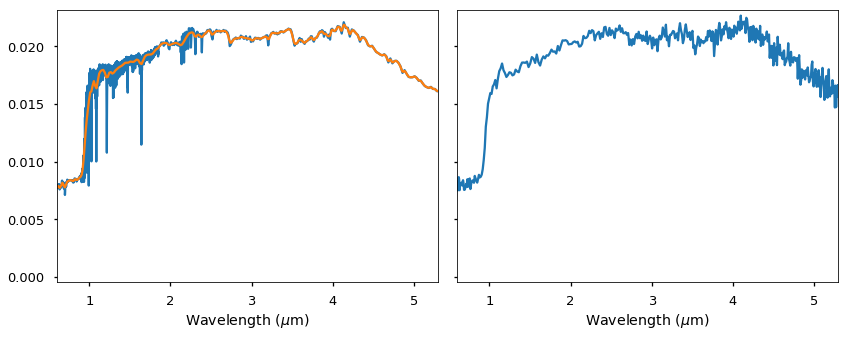

In [16]:
for ii in range(nspec):
    suffix = '{0:02d}'.format(ii)
    cat['SUFFIX'][ii] = suffix
    
    snrfile = os.path.join(jwstdir, 'etc', 'output', suffix, 
                           'lineplot', 'lineplot_sn.fits')
    snrspec = Table(fitsio.read(snrfile, ext=1, upper=True))
    outwave = snrspec['WAVELENGTH']
    npix = len(outwave)
        
    infile = os.path.join(jwstdir, 'etc', 'input', 'modelspec_{0:02d}.txt'.format(ii))
    inwave, influx = np.loadtxt(infile, unpack=True) # flux in mJy
    
    resolution = np.interp(inwave, disp['WAVELENGTH'], disp['DLDS'])    
    smoothflux = smoothspec(inwave, influx, resolution=resolution, smoothtype='lsf', 
                            outwave=outwave, fftsmooth=True)
    noisyferr = rand.normal(scale=smoothflux / snrspec['SN'], size=npix)
    noisyflux = smoothflux + noisyferr
    cat['JWST_WAVELENGTH'] = outwave * 1e4
    cat['JWST_FLUX'] = noisyflux / maggies2mJy # [maggies]
    cat['JWST_FERR'] = noisyferr / maggies2mJy # [maggies]
    cat['RESOLUTION'] = np.interp(outwave * 1e4, disp['WAVELENGTH'] * 1e4, disp['DLDS'] * 1e4)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
    ax[0].plot(inwave, influx)
    ax[0].plot(outwave, smoothflux)
    ax[1].plot(outwave, noisyflux)
    
    for xx in ax:
        xx.set_xlabel('Wavelength ($\mu$m)')
        xx.set_xlim(0.6, 5.3)
        xx.margins(0.02)
    
    fig.subplots_adjust(wspace=0.05)

In [17]:
catfile = os.path.join( jwstdir, 'spsmodeling', '{}_catalog.fits'.format(prefix) )
print('Writing {}'.format(catfile))
cat.write(catfile, overwrite=True)
cat

Writing /Users/ioannis/research/projects/jwstclusters/spsmodeling/prism_catalog.fits


WAVELENGTH [5994],FLUX [5994],ID,ZRED,ZFORM,LOGMASS,LOGZSOL,TAU,TAGE,ABMAG [10],SUFFIX,JWST_WAVELENGTH [403],JWST_FLUX [403],JWST_FERR [403],RESOLUTION [403]
um,mJy,,,,solMass,,Gyr,Gyr,,,,,,
float32,float32,int64,float64,float32,float32,float32,float32,float32,float32,bytes2,float32,float32,float32,float32
0.02275 .. 25000.0,6.53212e-11 .. 9.22875e-10,0,1.5,5.0,11.0,0.0,0.01,3.04597,23.3007 .. 24.4463,00,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685
0.03185 .. 35000.0,3.16327e-10 .. 5.91582e-10,1,2.5,5.0,11.0,0.0,0.01,1.41879,23.3453 .. 26.6594,01,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685
0.02275 .. 25000.0,1.15794e-09 .. 1.58515e-09,2,1.5,5.0,11.0,0.0,3.0,3.04597,22.5167 .. 21.5585,02,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685
0.03185 .. 35000.0,3.71637e-10 .. 8.18836e-10,3,2.5,5.0,11.0,0.0,3.0,1.41879,22.9028 .. 21.8557,03,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685
0.02275 .. 25000.0,2.71474e-10 .. 7.14375e-10,4,1.5,5.0,11.0,-0.69897,0.01,3.04597,23.2575 .. 23.6626,04,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685
0.02275 .. 25000.0,5.03517e-08 .. 1.22187e-09,5,1.5,5.0,11.0,-0.69897,3.0,3.04597,22.5928 .. 21.368,05,6024.96 .. 52975.7,2.24201e-09 .. 4.58487e-09,8.9678e-11 .. 1.42131e-10,43.1388 .. 74.5685


### Do the fitting and write out.

We write out the nestle results to an HDF5 file and the model as a pickle file.

In [18]:
def load_sps(resolution, resolution_wave, zred):
    t0 = time.time()
    print('Initializing CSPSpecBasis...')
    sps = CSPSpecBasis(zcontinuous=1, compute_vega_mags=False, vactoair_flag=False)
    print('...took {:.1f} seconds.'.format(time.time() - t0)) 
    
    assert sps.ssp.libraries[1] == 'miles', "Please change FSPS to the MILES libraries."

    restwave = resolution_wave / (1 + zred)
    delta_v = 2.998e5 * resolution / restwave
    
    sps.ssp.params['smooth_lsf'] = True
    sps.ssp.set_lsf(restwave, delta_v)
        
    return sps

In [19]:
for ii in range(1):
#for ii in range(nspec):
    run_params = load_run_params(prefix, seed=seed, resolution=cat['RESOLUTION'][ii])
    
    obs = load_obs(zred=cat['ZRED'][ii], wave=cat['JWST_WAVELENGTH'][ii], 
                   flux=cat['JWST_FLUX'][ii], ferr=cat['JWST_FERR'][ii])

    model = load_model(zred=obs['zred'], seed=run_params['seed'])
    
    sps = load_sps(cat['RESOLUTION'][ii], cat['JWST_WAVELENGTH'][ii], cat['ZRED'][ii])
    
    print('Starting nestle at {}'.format(time.asctime()))
    tstart = time.time()
    nestleout = nestle.sample(lnprobfn, model.prior_transform, model.ndim, rstate=rand,
                              callback=None, pool=None, 
                              method=run_params['nestle_method'],
                              npoints=run_params['nestle_npoints'],
                              maxcall=run_params['nestle_maxcall'])
    dur = time.time() - tstart
    print('Nestle took {:.2f} minutes'.format(dur / 60.0))
    
    # Write the HDF5 output file.
    hfilename = os.path.join( jwstdir, 'spsmodeling', '{}_prospect_{}_mcmc.h5'.format(
        run_params['prefix'], cat['SUFFIX'][ii]) )
    print('Writing HDF5 output file {}'.format(hfilename))
    hfile = h5py.File(hfilename, 'w')
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
    write_results.write_hdf5(hfilename, run_params, model, obs, 
                             nestleout, None, tsample=dur)
    hfile.close()    

    # Write the model object as a pickle.
    modelfile = os.path.join( jwstdir, 'spsmodeling', '{}_prospect_{}_model'.format(
        run_params['prefix'], cat['SUFFIX'][ii]) )
    print('Writing {}'.format(modelfile))
    partext = write_results.paramfile_string(**run_params)
    write_results.write_model_pickle(modelfile, model, paramfile_text=partext)
    
    # Also write the nestle outputs as a pickle.
    nestlefile = os.path.join( jwstdir, 'spsmodeling', '{}_prospect_{}_nmc.pkl'.format(
        run_params['prefix'], cat['SUFFIX'][ii]) )    
    print('Writing {}'.format(nestlefile))
    with open(nestlefile, 'wb') as f:
        pickle.dump(nestleout, f)

HARD-CODING THE PRIORS!!
Initializing CSPSpecBasis...
...took 11.4 seconds.


AttributeError: 'CSPSpecBasis' object has no attribute 'ssp'

### Read the results and generate QAplots.

In [ ]:
def _niceparnames(parnames):
    """Replace parameter names with nice names."""

    old = list([
        'tau',
        'logtau',
        'tage',
        'mass',
        'logmass',
        'logzsol',
        'dust2'])
    new = list([
        r'$\tau$ (Gyr)',
        r'$\log_{10}\, \tau$ (Gyr)',
        'Age (Gyr)',
        r'$M / M_{\odot}$',
        r'$\log_{10}\,(M / M_{\odot})$',
        r'$\log_{10}\, (Z / Z_{\odot})$',
        r'$\tau_{diffuse}$'])

    niceparnames = list(parnames).copy()
    for oo, nn in zip( old, new ):
        this = np.where(np.in1d(parnames, oo))[0]
        if len(this) > 0:
            niceparnames[this[0]] = nn
            
    return np.array(niceparnames)

In [ ]:
def _galaxysed(obs):
    """Generate the galaxy SED, converting from Angstroms to microns 
    and from maggies to mJy.

    """
    galaxywave = obs['wavelength'] * 1e-4 # micron --> Angstrom
    galaxyspec = obs['spectrum'] * maggies2muJy
    galaxyuncspec = obs['unc'] * maggies2muJy
    
    return galaxywave, galaxyspec, galaxyuncspec

In [ ]:
def _modelsed(model, theta, obs, sps):
    """Construct a model SED for a given set of parameters, converting
    from Angstroms to microns and from maggies to mJy.

    """
    modelwave = sps.csp.wavelengths * (1 + obs['zred']) # [observed-frame wavelengths]
    modelwave *= 1e-4 # micron --> Angstrom
    
    modelspec, modelphot, mextra = model.mean_model(theta, obs, sps=sps)
    modelspec *= maggies2muJy
    
    return modelwave, modelspec, modelphot

In [ ]:
def bestfit_sed(results=None, theta=None, obs=None, sps=None, 
                model=None, seed=None, nrand=100, start=50):
    """Plot the data and the best-fitting SED model.

    Either pass results (which contains chain, lnprobability, and weights) to 
    visualize samples from the posterior *or* theta and *obs* to visualize a 
    single SED fit.

    """
    rand = np.random.RandomState(seed)

    if results is not None:
        obs = results['obs']
    
    # Build the galaxy spectrum.
    galaxywave, galaxyspec, galaxyuncspec = _galaxysed(obs)
        
    # Build the maximum a posteriori model fit and also grab a random sampling of
    # the chains with weight equal to the posterior probability.    
    if results is not None:
        # Trim the first ~50 samples.
        chain = results['chain'][start:, :]
        lnp = results['lnprobability'][start:]
        weights = results['weights'][start:]

        niter, nparams = chain.shape

        theta = chain[lnp.argmax(), :] # maximum a posteriori values
        print(theta)

        #prob = np.exp(lnp - lnp.max())
        #prob /= prob.sum()
        rand_indx = rand.choice(niter, size=nrand, replace=False)#p=weights / np.sum(weights))
        theta_rand = chain[rand_indx, :]
        
    modelwave, modelspec, _ = _modelsed(model=model, theta=theta, obs=obs, sps=sps)

    # Establish the wavelength and flux limits.
    #minwave, maxwave = 0.1, 6.0
    minwave, maxwave = np.min(galaxywave), np.max(galaxywave)

    inrange = (modelwave > minwave) * (modelwave < maxwave)
    #print(modelwave.min(), modelwave.max(), minwave, maxwave)
    #maxflux = np.hstack( (galaxyspec, modelspec[inrange]) ).max() * 1.05
    maxflux = np.hstack( (galaxyspec, modelspec) ).max() * 1.2
    minflux = -0.05 * maxflux

    fig, ax = plt.subplots(figsize=(12, 8))
    if chain is not None:
        for ii in range(nrand):
            _, r_modelspec, _ = _modelsed(model=model, theta=theta_rand[ii, :], obs=obs, sps=sps)
            ax.plot(galaxywave, r_modelspec, alpha=0.2, color='gray')
    ax.plot(galaxywave, modelspec, alpha=1.0, label='Maximum Likelihood Fit')
    #ax.plot(modelwave, modelspec, alpha=1.0, label='Model spectrum')

    ax.errorbar(galaxywave, galaxyspec, galaxyuncspec, alpha=0.8, 
                label='Observed Spectrum')
                
    ax.set_xlabel(r'Observed-Frame Wavelength (${}$m)'.format('\mu'))
    ax.set_ylabel('Flux Density ($\mu$Jy)')
    ax.set_xlim(minwave, maxwave)
    ax.set_ylim(minflux, maxflux)
    ax.legend(loc='upper right', fontsize=16, frameon=False)
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.12, top=0.95)

    return fig

In [ ]:
def subtriangle(results, showpars=None, start=50, thin=1, truths=None, 
                trim_outliers=None, extents=None, **kwargs):
    """Generate a triangle / corner plot.
    
    """
    import corner as triangle

    # pull out the parameter names and flatten the thinned chains
    parnames = results['theta_labels']
    
    chain = results['chain'][start::thin, :]
    weights = results['weights'][start::thin]

    # logify mass
    if 'mass' in parnames and 'logmass' not in parnames:
        midx = np.where(np.in1d(parnames, 'mass'))[0]
        if len(midx) > 0:
            flatchain[:, midx[0]] = np.log10(flatchain[:, midx[0]])
            parnames[midx[0]] = 'logmass'
    parnames = np.array(parnames)

    # restrict to parameters you want to show
    if showpars is not None:
        ind_show = np.array([p in showpars for p in parnames], dtype=bool)
        flatchain = flatchain[:, ind_show]
        #truths = truths[ind_show]
        parnames = parnames[ind_show]

    # Make nice labels.
    niceparnames = _niceparnames(parnames)
        
    if trim_outliers:
        trim_outliers = len(parnames) * [trim_outliers]

    fig = triangle.corner(chain, weights=weights, labels=niceparnames, truths=truths,  
                          verbose=False, quantiles=[0.25, 0.5, 0.75], range=trim_outliers,
                          color='k', **kwargs)
    
    return fig

In [ ]:
def read_nestle(prefix, suffix):
    """Read the nestle output files.
        
    """
    import pickle
    from prospect.io import read_results
    
    #nestlefile = os.path.join( jwstdir, 'spsmodeling', '{}_prospect_{}_nmc.pkl'.format(prefix, suffix) )
    #print('Reading {}'.format(nestlefile))
    #with open(nestlefile, 'rb') as f:
    #    results = pickle.load(f)    
        
    hdf5file = os.path.join( jwstdir, 'spsmodeling', '{}_prospect_{}_mcmc.h5'.format(prefix, suffix) )
    print('Reading {}'.format(hdf5file))
    results, _, model = read_results.results_from(hdf5file)
    
    

    return results

In [ ]:
for ii in range(1):
    truths = (cat['LOGMASS'][ii], cat['LOGZSOL'][ii], cat['TAU'][ii], cat['TAGE'][ii])
    results = read_nestle(run_params['prefix'], cat['SUFFIX'][ii])
    
    fig = bestfit_sed(results, sps=sps, model=model, seed=results['run_params']['seed'])
    
    fig = subtriangle(results, truths=truths)

In [ ]:
results['theta_labels']